# Dynamic Time Warping for Sequence-to-Sequence mapping of vector data

**Dates:**  
31/10/2023: v0.8.0 on win11

### Modifications
31/10/2023:  use single quotes for formatting text in mpl.ax.text() to avoid FutureWarning


### DP Formulas

This DTW will find the alignment {(X_i(s),Y_j(s)), s=1:N} that minimizes:   
>    Sum_s \[ m_t \*||X_i(s)- Y_j(s)||^p + a_t \]  

with constraints   
>    i(1)=j(1)=1  ,  i(N)=Nx,j(N)=Ny   i(s)>=i(s-1),j(s)>=j(s-1),   
>    further subject to transition constraints (s-1)=>(s) and m_t and a_t transition costs

#### Data Structures

Feature Sequences are represented as

X(Nx,D), Y(Ny,D), ...  i.e. numpy arrays of size (number of frames, number of features)   

A 1D array of length N is cast to a a 2D array of size (N,1)
Therefore a single feature of width D must be explicitly passed as a (1,D) 2D array

In [2]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

## Example 1:  1D feature vectors
- first define two some sequences   
    The feature vectors are scalars (1D vectors) 
- run a standard DTW algorithm on it and print a trellis   
    The local distance metric applied is 'Euclidean Squared' and use the Levenshtein algorithm for aligning, i.e.
    we can move diagonal, horizontal or vertical (always in the direction of time)

In [3]:
x1d = np.array([.05, -.1, 0.77, .335, .95, 1.75])
y1d = np.array([0.,1.,2.])
# we also define some plotting arguments for this example
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':5,'ftr_scale':.15,'fmt':"{:.3f}",'text_size':"xx-small"}

DTW distance: 3.067 


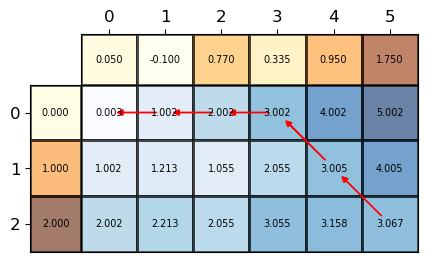

In [4]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,trans='LEV',result='details')
print("DTW distance: %.3f " % dist)

dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)

## Steps in the DTW algorithm
1. Local Distance Computation
Compute for each pair (x_i, y_j) a distance.  This feature by feature distance, organized in a matrix is called the "local distance matrix"
2. Trellis Computation
In a trellis we compute accumulated distances.  Each cell contains a sum of local distances , starting up to the current cell.
Thus cell (Nx,Ny) contains the full sequence distance.   
Obviously the computation of cummulative distance this is subject to the allowed transitions.  
To maintain the memory of how we moved from one cell to another
we add backpointers in each cell
3. Backtracking
In order to find the alignment between the two sequences. We follow backpointers from the end back to the start

### Trellis Representation
The trellis is a matrix arrangement in which each cell (i,j) says something about the relationship between x\[i\] and y\[j\] or up to that moment in time for both sequences.   
We tend to add extra space in the plot for the feature vectors, typically clearly visable by the different colormaps.

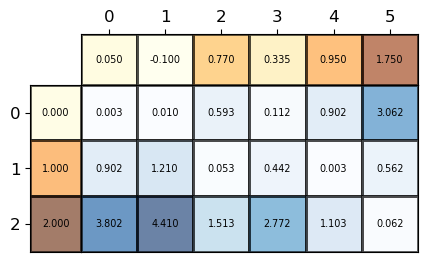

In [5]:
#STEP1: Compute the local distance matrix
fig1 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=ld_matrix,**plt_args)
fig1

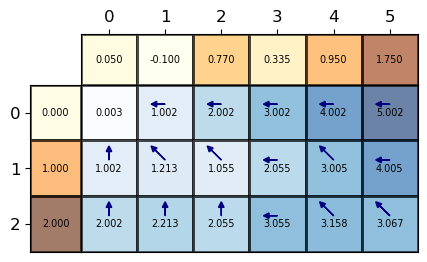

In [6]:
# STEP2: Compute the Cummulative Distance Matrix and add backpointers
fig2 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,bptrs=bptrs,**plt_args)
fig2

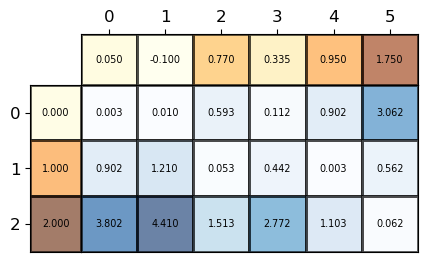

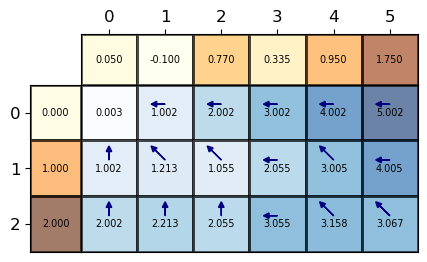

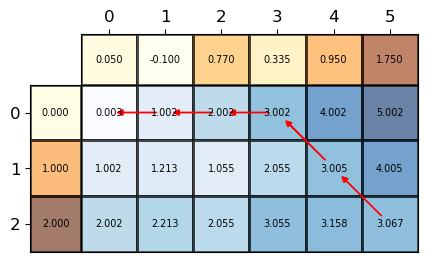

In [7]:
# STEP 3: Follow the backpointers in reverse order from end to beginning to find the optimal alignment
#xy_annot=True,ftr_annot=True,fig_width=4,fmt="{:.3f}",text_size="x-small"

fig3 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig1,fig2,fig3)

In [8]:
x_wp,y_wp = dtw.warp(x1d,y1d,trace)
pd.DataFrame((x_wp,y_wp))

,0,1,2,3,4,5
0,0.05,-0.1,0.77,0.335,0.95,1.75
1,0.00,0.0,0.00,0.000,1.00,2.00


In [9]:
# We can simply show the aligned versions of both sequences as well
dtw.align(x1d,y1d,trace).T

,0,1,2,3,4,5
x,0.05,-0.1,0.77,0.335,0.95,1.75
y,0.00,0.0,0.00,0.000,1.00,2.00


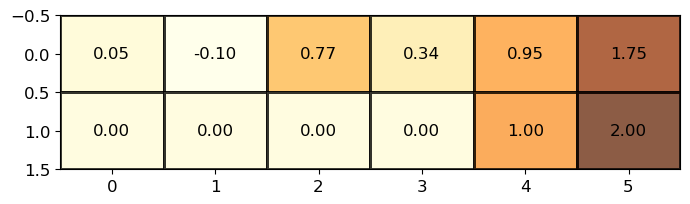

In [10]:
f,ax=plt.subplots(figsize=(8,2))
ax.invert_yaxis()
dtw.text_heatmap(np.array([x_wp,y_wp]),ax=ax,annot=True,edgecolor='k',cmap='YlOrBr',alpha=.75)

In [13]:
def plot2(x=None,y=None,trace=None,dist=None,down_sample=1,figsize=(10,4),cmap='YlOrBr',alpha=0.7):
    '''
    plots linear alignment
    '''
    if x.ndim == 1 : x=x.reshape(-1,1)
    if y.ndim == 1 : y=y.reshape(-1,1)
    xrange = [-.5,max(x.shape[0],y.shape[0])-.5]
    fig = Spd.SpchFig(row_heights=[2. , 1., 2.], figsize=figsize )
    
    fig.add_img_plot(y.T,iax=0,cmap=cmap,alpha=alpha)

    fig.add_img_plot(x.T,iax=2,cmap=cmap,alpha=alpha)
    for ax in fig.axes:
        ax.set_xlim(xrange)
        ax.axis('off')
    for i in range(len(y)):
        fig.axes[0].text(i,0,y[i])
    for i in range(len(x)):
        fig.axes[2].text(i,0,x[i])        
        
    fig.axes[1].set_ylim([-1.,1.])
    ax = fig.axes[1]

    if trace is None:
        if len(x) == len(y):
            trace = []
            for i in range(len(y)): trace.append([i,i])
            
    if trace is not None:

        for i in range(0,len(trace),down_sample) :
            ax.plot(trace[i],[-1,1],linestyle='dashed',color='k')        
        if dist is not None:
            for i in range(0,len(trace),down_sample) :
                ax.text((trace[i][0]+trace[i][1])/2.,0,'{:.2f}'.format(dist[i]))
                #ax.text(trace[i],[-1,1],linestyle='dashed',color='k'
    return(fig)

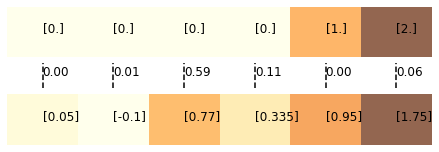

In [14]:
plot2(x_wp,y_wp,None,np.square(x_wp-y_wp),figsize=(6,2))

### Use of subfigures to get side by side displaying

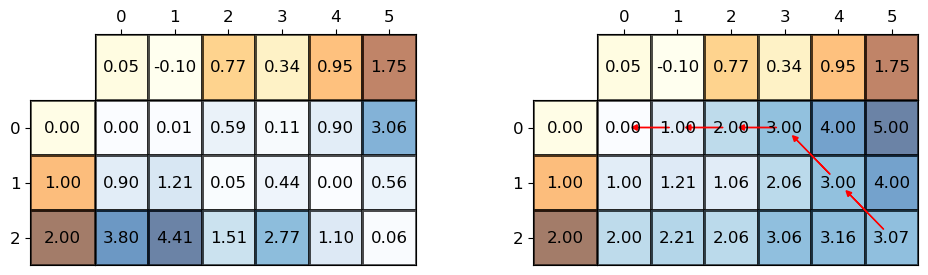

In [15]:
fig = plt.figure( figsize=(10, 3))
subfigs = fig.subfigures(1, 2, wspace=.01)
# plotting local distance matrix and both x- and y-features
dtw.plot_trellis(fig=subfigs[0],x=x1d,y=y1d,xy_mat=ld_matrix,xy_annot=True,ftr_annot=True)
dtw.plot_trellis(fig=subfigs[1],x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,xy_annot=True,ftr_annot=True)
display(fig)

## Example with Strings and Characters

Levenshtein distance was originally developed for character string matching in which 3 basic operations were
defined: Subsititution, Insertion, Deletion.  There was no concept of 'local distances', only of costs related to the different type of operations.

For equal penalties, the Levenhstein distance computation is equally well implemented with the DTW algorithm
and the local distance concept where non matching entries get a cost
and matching entries a zero cost.  That combined with the Levenshtein moves leads to a Levenshtein matching.




In [16]:
#
# Define a few utility functions that deal with character match/mismatch
#
def letter_class(a):
    if a.lower() in 'aeiou' : return('VOWEL')
    elif a.lower() in 'pbtdkg' : return('PLOSIVE')
    elif a.lower() in 'mnlr' : return('LIQUID')
    elif a.lower() in 'sfzvc' : return('FRICATIVE')
    else: return(None)
    
def letter_sym(a,b):
    '''
    a very ad hoc sound similarity measure between letters
    returns
        0: a == b
        1: class(a) == class(b)  for defined classes 
        2: otherwise
    '''
    _DIFFERENT = 1.
    _SIMILAR = .6
    _SAME = 0
    
    if a == b: return(_SAME)
    class_a = letter_class(a)
    class_b = letter_class(b)
    if class_a is None or class_b is None: return(_DIFFERENT)
    if class_a == class_b: return(_SIMILAR)
    else: return(_DIFFERENT)

def letter_sym_matrix(x,y):
    '''
    constructs sound similarity matrix for arrays x and y
    '''
    x = x.flatten()
    y = y.flatten()
    Nx = len(x)
    Ny = len(y)
    dist_matrix = np.zeros((Nx,Ny),dtype='float32')
    for i in range(Nx):
        for j in range(Ny):
            dist_matrix[i,j] = letter_sym(x[i],y[j])
    return(dist_matrix)

def ld_rand(x,y):
    Nx = len(x)
    Ny = len(y)
    dist_matrix = np.random.rand(Nx,Ny) 
    return(dist_matrix)

In [17]:
# Add a dummy symbol at beginning if you want to allow for initial insertions/deletions
syms = ['nebukadnezar','nabukodonosor']
syms = ['volodomir','vladimirski']
syms= ['recognize speech','wreck a nice beach']
syms = ['in the skies','in disguise']
#syms = ['albert einstein','max levenshtein']
#syms = ['law and order','laura norder']
syms = ['this evening','deceiving']
#
x_str = np.array(list(syms[0]))
y_str = np.array(list(syms[1]))  
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':8,'ftr_scale':.07,'text_size':'small','ftr_args':{'alpha':.2}}

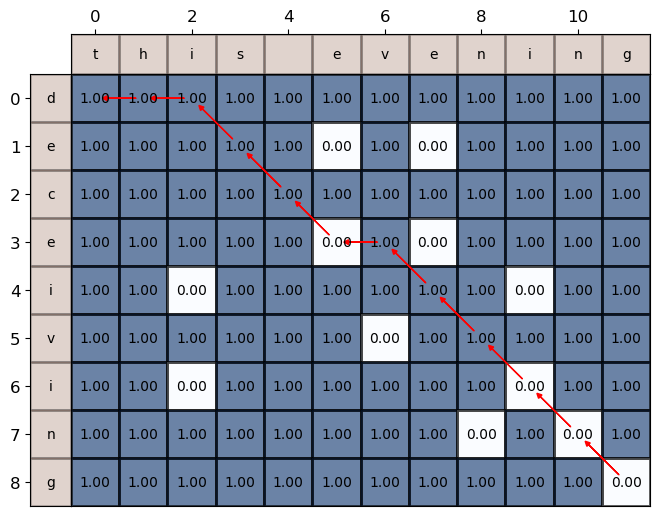

DTW distance =  8.0


,0,1,2,3,4,5,6,7,8,9,10,11
x,t,h,i,s,,e,v,e,n,i,n,g
y,d,_,_,e,c,e,_,i,v,i,n,g
E,S,I,I,S,S,H,I,S,S,H,H,H


In [18]:
# Levensthein distance allows for  INS/SUB/DEL
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV',
                                               result='details',p="hamming")
fig = dtw.plot_trellis(x=x_str,y=y_str,xy_mat=ld_matrix,trace=trace,**plt_args)

display(fig)
print("DTW distance = ",dist)
display(dtw.align(x_str,y_str,trace,EPS='_').T)

## Character mismatch costs
Character specific mismatch costs are easily added to the concept when using the DTW algorithm to implement Levenshtein style sequence matching.  In the example below we pass our very ad hoc 'letter_sym_matrix' similarity function which gives smaller penalties when
vowels match vowels, plosives match plosives, ..

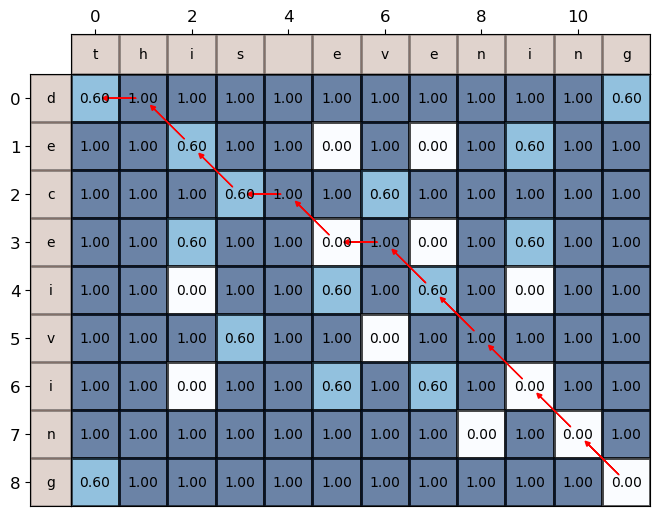

DTW distance =  6.400000095367432


,0,1,2,3,4,5,6,7,8,9,10,11
x,t,h,i,s,,e,v,e,n,i,n,g
y,d,_,e,c,_,e,_,i,v,i,n,g
E,S,I,S,S,I,H,I,S,S,H,H,H


In [19]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV', ld_func=letter_sym_matrix,
                                               result='details',p="hamming")
fig = dtw.plot_trellis(x=x_str,y=y_str,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)
display(dtw.align(x_str,y_str,trace,EPS='_').T)

## Multi-dimensional Features
In this exampe we pass 2D feature vectors

In [20]:
#x2d = np.array([[0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],[0.3,1.3,1.5,1.5,1.,0.3,-0.24,0.3,.05]]).T
x2d = np.array([[0.,1.,2.,1.,0.,0.1,.05],[0.3,1.3,1.5,1.5,1.,0.3,.05]]).T
y2d = np.array([[0.,0.,0.,1.,2],[1.,1.,1.,1.,-1]]).T + .1*np.random.rand(5,2)
plt_args = {'xy_annot':True,'ftr_annot':True,            
            'xy_args':{'alpha':.2,'edgecolor':'k'}, 
            'bptr_args':{'color':'orange','linewidth':3},
            'ftr_args':{'cmap':'YlOrBr','edgecolor':'g','alpha':.3}
            }

x_ftrs=x2d
y_ftrs=y2d

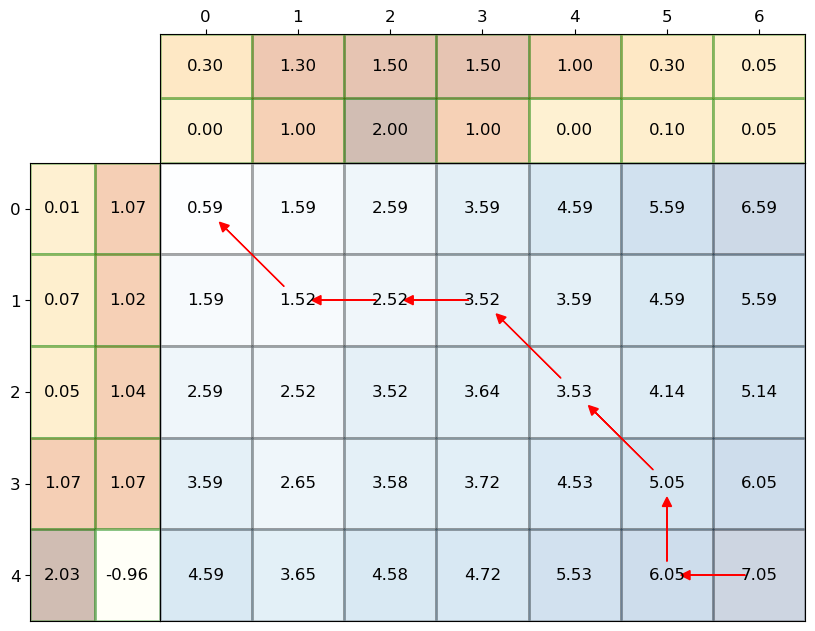

DTW distance =  7.05105911473675


In [21]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='LEV',result='details',CLIP=True)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

## ITAKURA constraints
Long verticle or horizontal segments in the alignment are indications of true mismatch at those locations.
Good alignments typical are close to the diagonal or at least have mostly diagonal fragments.

For speech in particular speaking rate differences tend to be limited.
Hence popular in the speech community are the so called ITAKURA onstraints in sequence matching.   
Itakura allows single jump in x or y direction while the other index just increases by 1 .  
In the dtw.dtw() implementation we penalize the jump moves by 20% vs. regular diagonal moves, to account for this less than optimal alignment.       
This allows for a speedup of x2 on either axis    
ITAKURA and LEVENSHTEIN are SYMMETRIC 
In the plot below we show the cummulative distance matrix.  
The high values in lower left and upper right corners basically indicate regions that are not reachable with
ITAKURA constraints starting from the origin.


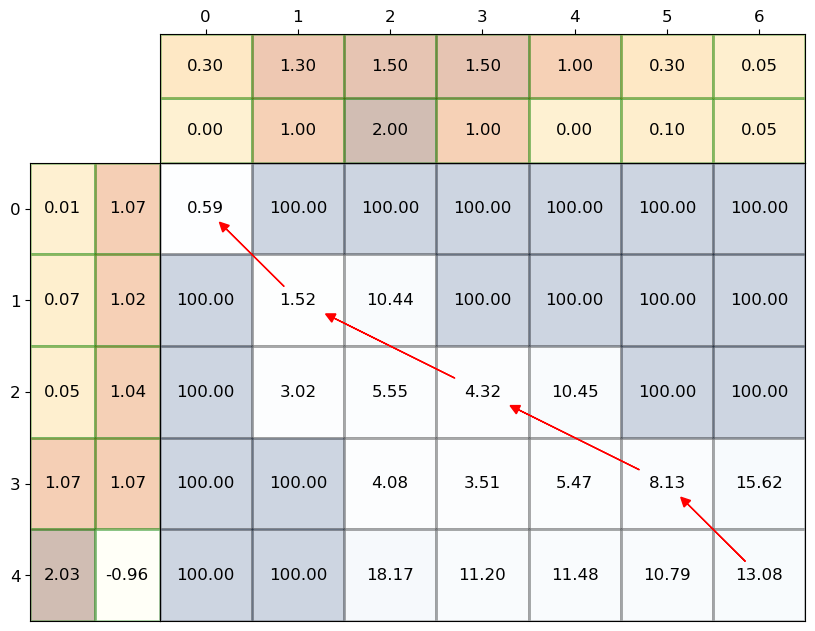

DTW distance =  13.080165729814409


In [22]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='ITA',result='details',CLIP=True)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

# Now with speech data

In [23]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/audio/'
# sa1: she had your dark suit in greasy washwater all year
# sa2: don't ask me to carry an oily rag like that
# note there are some word segmentation errors in sa1, phn segmentations are OK

yname = dir+'train/dr1/fcjf0/sa2'
xname = dir+'train/dr1/fdaw0/sa2'

xwavdata, sr = Spch.load(xname+".wav")
ywavdata, sr = Spch.load(yname+".wav")

xsegdata = Spch.read_seg_file(xname+ ".wrd",dt=1/sr,fmt='float32')
ysegdata = Spch.read_seg_file(yname+ ".wrd",dt=1/sr,fmt='float32')
# compute a spectrogram with default parameters

n_mels = None
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
#
xspgdata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=None)
xmeldata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=24)
(nparam,xnfr)=xspgdata.shape
d_freq = sr/(2.*(nparam-1))
yspgdata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=None)
ymeldata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=24)

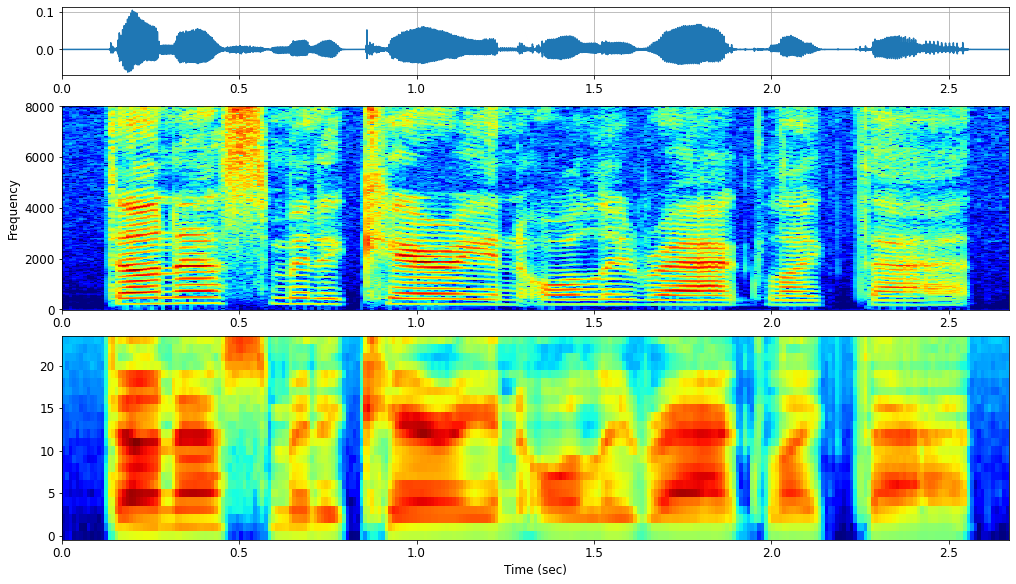

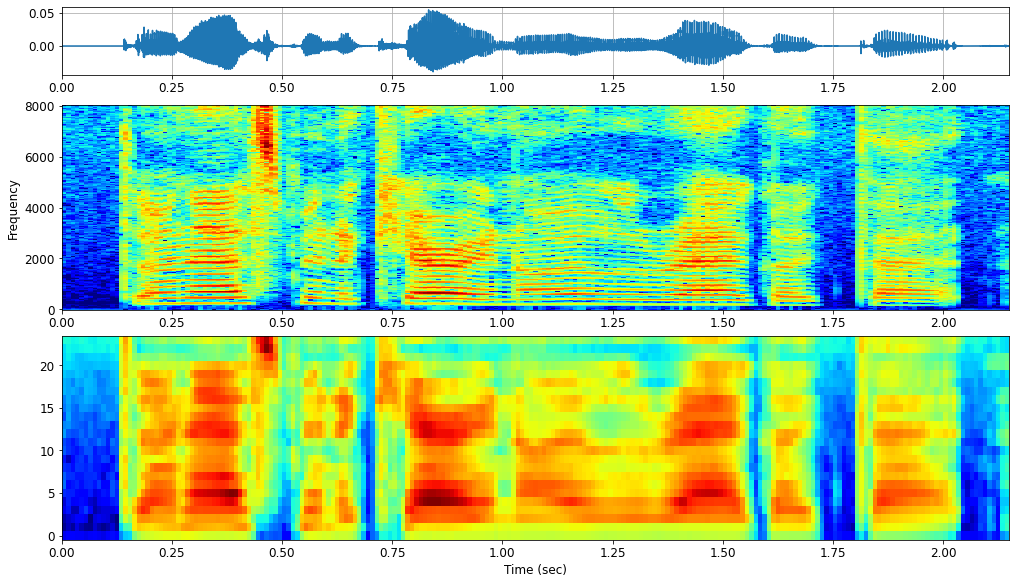

In [24]:
# just displaying the spectrograms and mel spectrograms of both sentences
fig = Spd.PlotSpgFtrs(wavdata=xwavdata,spgdata=xspgdata,#segwav=xsegdata,
                      img_ftrs=[xmeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)
#
fig = Spd.PlotSpgFtrs(wavdata=ywavdata,spgdata=yspgdata, #segwav=ysegdata,
                  img_ftrs=[ymeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)

## pc

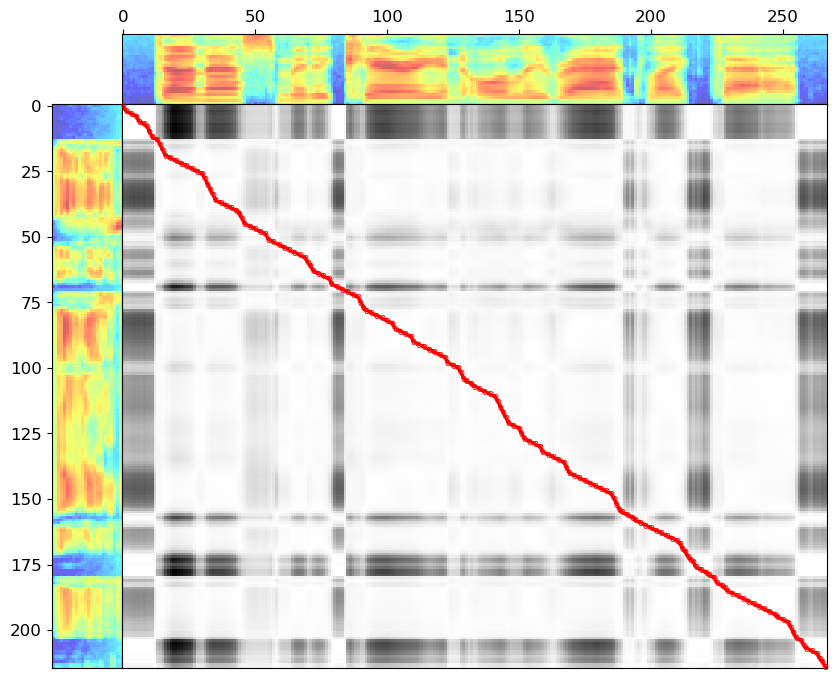

In [25]:
plt_args = {'fig_width':10,'ftr_scale':.1,'ftr_args':{'cmap':'jet','edgecolor':None},
            'xy_args':{'cmap':'Greys','alpha':1} }
x_ftrs = xmeldata.T
y_ftrs = ymeldata.T
#x_ftrs = xspgdata.T
#y_ftrs = yspgdata.T

cost,trace,ld_matrix,cd_matrix,_ = dtw.dtw(x_ftrs,y_ftrs,trans='ITA',result='details')
fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=y_ftrs,x=x_ftrs,**plt_args)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,x=x_ftrs,y=y_ftrs)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=yspgdata[0:255,:].T,x=xspgdata[0:255,:].T,**plt_args)
fig

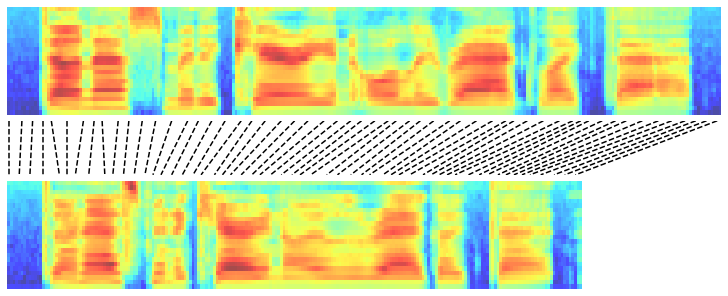

In [26]:
dtw.align_plot(x_ftrs,y_ftrs,trace,cmap='jet',down_sample=3)

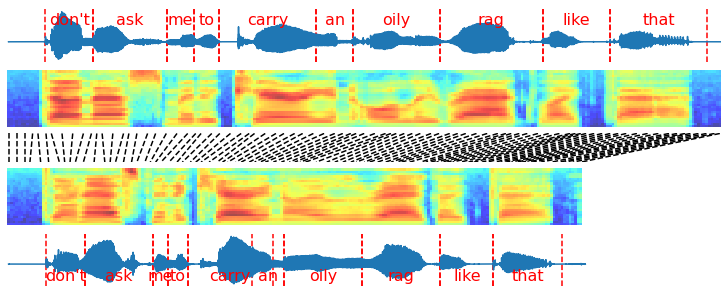

In [27]:
dtw.align_plot(x_ftrs,y_ftrs,trace,x_wav=xwavdata,y_wav=ywavdata,x_seg=xsegdata,y_seg=ysegdata,cmap='jet',down_sample=2)

In [ ]:
_ftr_args={'cmap':'YlOrBr','alpha':0.6,'edgecolor':'k','linewidth':1}
_ftr_args.update({'edgecolor':None})  
_ftr_args

In [ ]:
N=200
D = 1
if N>20 | D>5:
    print("ha")
    _ftr_args.update({'ba':3})
_ftr_args

In [ ]:
cd_matrix.shape, np.max(ld_matrix), np.max(cd_matrix)

In [ ]:
np.min([np.inf,37934])

In [ ]:
ld_matrix[0:2,0:4], cd_matrix[0:2,0:4]

In [ ]:
## pcolormesh debugging

In [ ]:
Dims = (100,200)
data = np.random.rand(300,400)
#data = xspgdata[:,0:250]
fig,ax = plt.subplots(1,dpi=192,figsize=(10,10))
ax.pcolormesh(data,cmap='jet',alpha=.7,linewidth=1,edgecolor='k')
#fig

In [ ]:
x_ftrs = xmeldata.T
y_ftrs = ymeldata.T
cost,trace,ld_matrix,cd_matrix,_ = dtw(x_ftrs,y_ftrs,trans='ITA',result='details')
fig = dp_plot_1d(x_ftrs=x_ftrs,y_ftrs=y_ftrs,trace=trace,down_sample=3)
fig

In [ ]:
# plotting alignments via superposition 
def plot_align_1d(x_ftrs,y_ftrs,*,x_wav=None,y_wav=None,x_seg=None,y_seg=None,shift=.01,sr=16000,trace=None,down_sample=1):
    
    if x_wav is None or y_wav is None:
        WavPlot = False
        row_heights = [1.,.5,1.]
        figsize = (12,5)
        ax_x = 0
        ax_tr = 1
        ax_y = 2
    else:
        row_heights = [1., 1., .5, 1., 1.]
        WavPlot = True
        figsize = (12,7)
        ax_xwav = 0
        ax_x = 1
        ax_tr =2
        ax_y = 3
        ax_ywav = 4
        
    xrange = np.array([-.5,max(x_ftrs.shape[0],y_ftrs.shape[0])-.5])*shift
    fig = Spd.SpchFig(row_heights=row_heights, figsize=figsize )
    
    if WavPlot:
        fig.add_line_plot(ywavdata,iax=ax_ywav,dx=1/sr)
        fig.add_line_plot(xwavdata,iax=ax_xwav,dx=1/sr)
        if x_seg is not None:
            fig.add_seg_plot(x_seg,iax=ax_xwav,ypos=0.8)
        if y_seg is not None:
            fig.add_seg_plot(y_seg,iax=ax_ywav,ypos=0.2)            
        
    fig.add_img_plot(y_ftrs.T,iax=ax_y,dx=shift)   
    fig.add_img_plot(x_ftrs.T,iax=ax_x,dx=shift)
    for ax in fig.axes:
        ax.set_xlim(xrange)
        ax.axis('off')

    fig.axes[ax_tr].set_ylim([-1.,1.])
    ax = fig.axes[ax_tr]
    for i in range(0,len(trace),down_sample) :
        ax.plot(trace[i]*shift,[1,-1],linestyle='dashed',color='k')        
        
    return(fig)

In [ ]:
fig = plot_align_1d(x_ftrs,y_ftrs,x_wav=xwavdata,y_wav=ywavdata,x_seg=xsegdata,y_seg=ysegdata,trace=trace,shift=shift,sr=sr,down_sample=3)
fig

In [ ]:
xsegdata

In [ ]:
fig.add_seg_plot(xsegdata,iax=0,ypos=0.8)
fig.add_seg_plot(ysegdata,iax=4,ypos=0.2)
fig

## Plotting Annotations instead of the original data

In [ ]:
# ... continuation of the 2D data
# same trellis plot , but with string annotations for the features
x_annot = np.array([ ["A","B","C","D","E","F","G","H","I"],["Ax","Bx","C","D","E","F","G","H","Ie"] ]).T
y_annot = np.array([ ["y1","y2","y3","y4","y5"], ["ABCD", "BCX","EFG","GHI","GHIx"] ]).T

x_ftrs = x_annot
y_ftrs = y_annot
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,xy_annot=True,ftr_annot=True,\
              xy_args={'alpha':.8,'edgecolor':'k'},ftr_args={'cmap':'YlOrBr','edgecolor':'r','alpha':.2})
fig

In [ ]:
def plot_xy_img(xy_mat=None,xy_line=None,x=None,y=None,x_annot=None,aspect='equal',xy_cmap='Blues',ftr_cmap='jet',
            ftr_fmt='img',
            width_ratios=None,height_ratios=None,ftr_scale=None,fig_width=10.,annot=False,**kwargs):
    '''
    ftr_scale defines fixed aspect ratio between ftr plots and matrix plot
    '''
    
    ny,nx = xy_mat.shape
    n = max(nx,ny)
    if (n > 50) & annot :
        print("WARNING(plot_xy): Annotation is turned off for dimensions > 50 !")
        annot = False
        
    if x is not None: _,dx = x.shape
    else: dx = 0
    if y is not None: _,dy = y.shape
    else: dy = 0    

    d = max(dx,dy)
    if ftr_scale is not None:

        if dx != 0 : dx = ftr_scale*n
        if dy != 0 : dy = ftr_scale*n
        
    if width_ratios is None:
        width_ratios = [ float(dy)/(nx+dy), float(nx)/(nx+dy) ]
    if height_ratios is None:
        height_ratios = [ float(dx)/(ny+dx), float(ny)/(ny+dx) ]
    fig_aspect = float(ny+dx)/float(nx+dy)
    fig = plt.figure(figsize=(fig_width,fig_width*fig_aspect) )
    gs = fig.add_gridspec(nrows=2,ncols=2,
                          width_ratios=width_ratios,
                          height_ratios=height_ratios ,
                          hspace=0., wspace=0. ) 
    ax_xy = fig.add_subplot(gs[1,1])
    ax_x = fig.add_subplot(gs[0,1])
    ax_y = fig.add_subplot(gs[1,0])


    
    for ax in [ax_xy, ax_x, ax_y]:
        #ax.xaxis.set_ticks_position('none')
        #ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    ax_x.xaxis.set_visible(True)
    ax_x.xaxis.set_ticks_position('top')
    ax_y.yaxis.set_visible(True)
    ax_y.yaxis.set_ticks_position('left')
    
    if annot == True:  # use seaborn if annotations are requested
        sns.heatmap(xy_mat,ax=ax_xy,annot=True,cmap=xy_cmap,cbar=False)        
        if xy_line is not None:
            sns.lineplot(x=xy_line[:,0]+0.5,y=xy_line[:,1]+0.5,ax=ax_xy,color='r',lw=2) 
    else:
        ax_xy.imshow(xy_mat,cmap=xy_cmap,aspect='auto')
        if xy_line is not None:
            ax_xy.plot(xy_line[:,0],xy_line[:,1],lw=3,color='r')
    #ax_x.sharex(ax_xy)
    #ax_y.sharey(ax_xy)
    if ftr_fmt == 'img':
        if x is not None: ax_x.imshow(x.T,cmap=ftr_cmap,aspect='auto',origin='lower')
        if y is not None: ax_y.imshow(y,cmap=ftr_cmap,aspect='auto')
    elif ftr_fmt == 'txt':
        if x is not None:
             
            for i in range(nx):
                for j in range(d):
                    ax_x.text(i, j,x_annot[j][i] ) # bbox=dict(fill=True, color='green', edgecolor='red', linewidth=2))
    plt.close()
    return fig

In [ ]:
# plots spectrograms in top and left positions

def dp_plot(x_ftrs=None,y_ftrs=None,xy_mat=None,trace=None,aspect=None,xy_cmap='Blues',
            ftr_plot='img',ftr_pos='bottom_left',edges=True,**kwargs):
    
    ## needed as long as pyspch works with (spg)data as in librosa 
    if x_ftrs is not None: x_ftrs = x_ftrs.T
    # if y_ftrs is not None: y_ftrs = y_ftrs.T
    ###
    
    # determine aspect ratio for matrix plot  (this is an approximate solution, not taking into account plot spacings)
    try:
        a = xy_mat.shape[1]/xy_mat.shape[0]
    except:
        a = 1.0
    a_fig = (1.+3.*a)/4. 
    if ftr_pos == 'top_right':
        fig = Spd.SpchFig(row_heights=[1. , 3.], col_widths=[3.*a,1.],figsize=(10,10*a_fig),**kwargs)
        fig.axes[1].set_visible(False)
        iax_x = [0,0]
        iax_y = [1,1]
        iax_mat = [1,0]
        invert_y = True
        invert_x = False
    if ftr_pos == 'top_left':
        fig = Spd.SpchFig(row_heights=[1. , 3.], col_widths=[1.,3.*a],figsize=(10,10*a_fig),**kwargs)
        fig.axes[0].set_visible(False)
        iax_x = [0,1]
        iax_y = [1,0]
        iax_mat = [1,1]
        invert_y = True
        invert_x = False
    elif ftr_pos == 'bottom_left':
        fig = Spd.SpchFig(row_heights=[3.,1.], col_widths=[1.,3.*a],figsize=(10,10*a_fig))
        fig.axes[2].set_visible(False)
        iax_x = [1,1]
        iax_y = [0,0]
        iax_mat = [0,1]
        invert_y = False
        invert_x = True
    
    if (xy_mat.shape[0] > 50): edges = False
    edgecolors='k' if edges  else None

    ax = fig.get_axis(iax_mat)
    if invert_y: ax.invert_yaxis()
    if xy_mat is not None:
        fig.add_img_plot(xy_mat.T,iax=iax_mat,edgecolors=edgecolors,cmap=xy_cmap)
    if trace is not None:
        fig.add_line_plot(x=trace[:,0],y=trace[:,1],iax=iax_mat,xrange=None,lw=3,color='r',grid=False)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    if x_ftrs is not None:
        ax = fig.get_axis(iax_x)
        if ftr_plot == 'img':
            fig.add_img_plot(x_ftrs,iax=iax_x,edgecolors=edgecolors)
            if aspect is not None: fig.gca().set_aspect('equal')
        elif ftr_plot == 'line':
            fig.add_line_plot(x_ftrs,iax=iax_x)
            ax.set_xlim(xlim)

    if y_ftrs is not None:   
        ax = fig.get_axis(iax_y)
        if invert_y: ax.invert_yaxis()
        if invert_x: ax.invert_xaxis()
        
        if ftr_plot == 'img':
            fig.add_img_plot(y_ftrs,iax=iax_y,edgecolors=edgecolors)
            if aspect is not None: fig.gca().set_aspect('equal')
        elif ftr_plot == 'line':
            fig.add_line_plot(y_ftrs.T,iax=iax_y,invert_xy=True)
            ax.set_ylim(ylim)
            

        
    return(fig)

In [ ]:
# plots spectrograms in top and right positions
def dp_plot_r(x_ftrs=None,y_ftrs=None,xy_mat=None,trace=None,ftr_plot='img'):
    
    try:
        a = xy_mat.shape[1]/xy_mat.shape[0]
    except:
        a = 1.0
    a_fig = (1.+3.*a)/4. 
    
    fig = Spd.SpchFig(row_heights=[1. , 3.], col_widths=[3.*a,1],figsize=(10,10*a_fig))
    fig.axes[1].set_visible(False)
    
    if x_ftrs is not None:
        if ftr_plot == 'img':
            fig.add_img_plot(x_ftrs.T,iax=[0,0])
        elif ftr_plot == 'line':
            fig.add_line_plot(x_ftrs.T,iax=[0,0])
            
    if y_ftrs is not None:   
        ax = fig.get_axis([1,1])

        if ftr_plot == 'img':
            fig.add_img_plot(y_ftrs,iax=[1,1])
            ax.invert_yaxis()
            #ax.invert_xaxis()
            #ax.imshow(y_ftrs)
        elif ftr_plot == 'line':
            #n = y_ftrs.shape[1]
            #print(n)
            #ax.plot(y_ftrs,np.arange(n).reshape(1,-1))
            fig.add_line_plot(y_ftrs.T,iax=[1,1],invert_xy=True)
            fig.axes[1]
            
    ax = fig.get_axis([1,0])
    ax.invert_yaxis()
    if xy_mat is not None:
        fig.add_img_plot(xy_mat.T,iax=[1,0])
        #ax.imshow(xy_mat.T,cmap='jet',aspect='auto')
    if trace is not None:
        fig.add_line_plot(x=trace[:,0],y=trace[:,1],iax=[1,0],xrange=None,lw=5,color='r',grid=False)
        
    return(fig)

